This is Python implementation of Bayesian linear regression with variational inference.
You can use 2 models as follows.

- BayesRidge
  - It is Bayesian Ridge regression. The penality term is automatically adjusted.
- ARD
  - It automatically executes variable selection thanks to the Automatic Relevance Determination(ARD) prior.

Drugowitsch(2013) shows the Variational Inference (VI) algorithm for these models.
I additionally implemented Stochastic Variational Inference (SVI) algorithm, which uses mini-batch samples in each update step, hence it is scalable for large dataset.

You can run these algorithms with `.fit(maxiter, batchsize)` method.
- `batchsize=None` -> run VI
- `batchsize=(positive integer value)` -> run SVI

I don't employ early stopping strategy for stability, so please check convergence (Evidence Lower Bound (=`.ELBO` attribute) is the sign inversed loss).

*References*
- Drugowitsch, J. (2013). Variational Bayesian inference for linear and logistic regression. arXiv preprint arXiv:1310.5438.
- Hoffman, M. D., Blei, D. M., Wang, C., & Paisley, J. (2013). Stochastic variational inference. The Journal of Machine Learning Research, 14(1), 1303-1347.
- Ranganath, R., Wang, C., David, B., & Xing, E. (2013, May). An adaptive learning rate for stochastic variational inference. In International Conference on Machine Learning (pp. 298-306). PMLR.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from BayesianRegressions import LinearRegressions

%load_ext autoreload
%autoreload 2

# Linear System

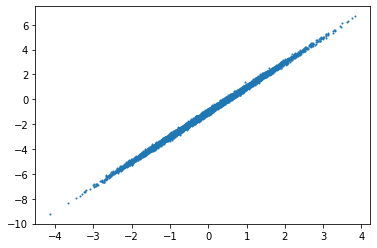

In [16]:
N = 10000
beta = np.array([2,0, -1])

X = np.random.normal(size=N)
X = np.concatenate((X[:,None], np.random.normal(size=(N,1)), np.ones((N, 1))), axis=1)

y = X @ beta + np.random.normal(scale=0.1, size=N)

plt.scatter(X[:,0], y, s=1);

ELBO=8802.14: 100%|██████████| 10/10 [00:00<00:00, 100.90it/s]


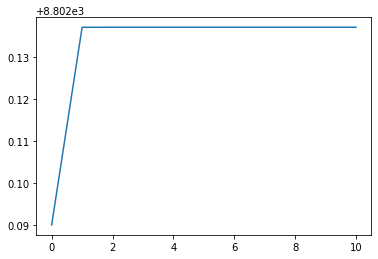

In [18]:
# model = LinearRegressions.ARD(y, X)
model = LinearRegressions.BayesRidge(y, X)
# batch learning
model.fit(maxiter=10, batchsize=None)
plt.plot(model.ELBO);

ELBO=9321.41: 100%|██████████| 1000/1000 [00:05<00:00, 172.96it/s]


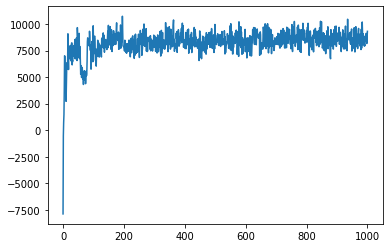

In [19]:
# mini-batch learning (SVI)
model.fit(maxiter=1000, batchsize=100)
plt.plot(model.ELBO);

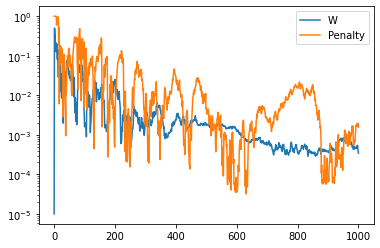

In [20]:
for key, lr in model.updater.lr.items():
    plt.plot(lr, label=key)
plt.yscale("log")
plt.legend();

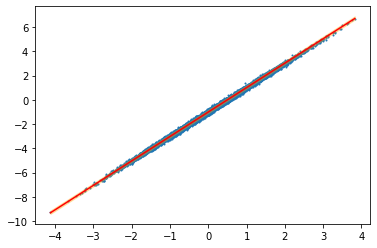

In [21]:
x_test = np.linspace(X[:,0].min(), X[:,0].max(), num=50, endpoint=True)
y_test, var_test = model.predict(np.concatenate([x_test[:,None], np.ones_like(x_test)[:,None], np.ones_like(x_test)[:,None]], axis=1), return_var=True)

plt.scatter(X[:,0], y, s=1)
plt.fill_between(x_test, y_test - np.sqrt(var_test), y_test + 2*np.sqrt(var_test), alpha=0.3, color="orange");
plt.plot(x_test, y_test, ls="-", c="r");

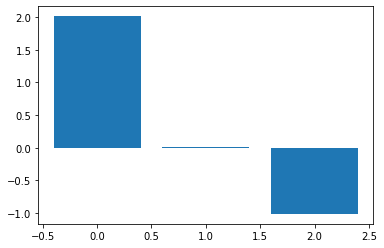

In [22]:
plt.bar(range(model.D), model.weights_);

# Non-linear System

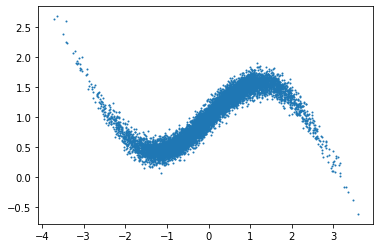

In [23]:
N = 10000
X = np.random.normal(size=N)
y = 1 + np.sin(X) -0.3 * X + np.random.normal(scale=0.1, size=N)

plt.scatter(X, y, s=1);

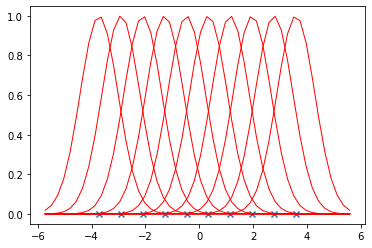

In [24]:
# base function
n_kernel = 10
centers = np.linspace(X.min(), X.max(), num=n_kernel)
def local_base_func(X, centers=centers, radius=1):
    dist2 = np.square(centers[None] - X[:,None])
    return np.exp(-dist2/radius)

x_test = np.linspace(X.min()-2, X.max()+2, num=50, endpoint=True)
phi_test = local_base_func(x_test)


for i in range(n_kernel):
    plt.plot(x_test, phi_test[:,i], c="r", ls="-", lw=1)
plt.scatter(centers, np.zeros_like(centers), marker="x");

ELBO=8306.93: 100%|██████████| 10/10 [00:00<00:00, 66.17it/s]


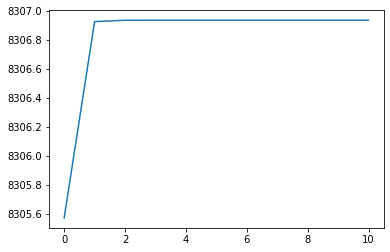

In [25]:
# model = LinearRegressions.ARD(y, local_base_func(X))
model = LinearRegressions.BayesRidge(y, local_base_func(X))

model.fit(maxiter=10, batchsize=None)
plt.plot(model.ELBO);

ELBO=7589.83: 100%|██████████| 1000/1000 [00:06<00:00, 157.89it/s]


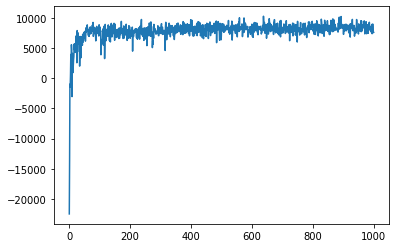

In [26]:
model.fit(maxiter=1000, batchsize=100)
plt.plot(model.ELBO);

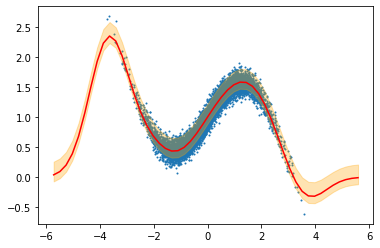

In [27]:
y_test, var_test = model.predict(local_base_func(x_test), return_var=True)

plt.scatter(X, y, s=1)
plt.fill_between(x_test, y_test - np.sqrt(var_test), y_test + 2*np.sqrt(var_test), alpha=0.3, color="orange");
plt.plot(x_test, y_test, c="r", ls="-");

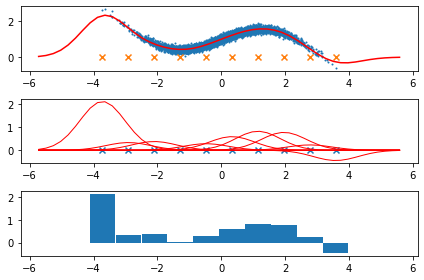

In [28]:
ax = plt.subplot(3,1,1)
plt.scatter(X, y, s=1)
plt.plot(x_test, model.predict(local_base_func(x_test)), c="r", ls="-");
plt.scatter(centers, np.zeros_like(centers), marker="x");

plt.subplot(3,1,2, sharex=ax)
for i in range(n_kernel):
    plt.plot(x_test, phi_test[:,i]*model.weights_[i], c="r", ls="-", lw=1)
plt.scatter(centers, np.zeros_like(centers), marker="x");

plt.subplot(3,1,3, sharex=ax)
plt.bar(centers, model.weights_)

plt.tight_layout();